In [97]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%run phasedecoder907.ipynb
from src.folder_handler import *
from src.cort_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import math
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/3-lemons919__session.pkl', 'rb') as inp:
    lem919_session = pickle.load(inp)
lem919_rates = lem919_session.data['rates']
lem919_angles = lem919_session.data['angles']
lem919_coords = lem919_session.data['coords']

with open('/mnt/c/oobootoo/rat-fes/data/pickles/3-meepo919__session.pkl', 'rb') as inp:
    mep919_session = pickle.load(inp)
mep919_rates = mep919_session.data['rates']
mep919_angles = mep919_session.data['angles']
mep919_coords = mep919_session.data['coords']

In [3]:
lem919arctans, lem919phase_list, lem919H_sin, lem919H_cos, lem919r, lem919full_rates = phase_train(lem919_rates, lem919_angles)
lem919tsf = np.linspace(0, (lem919phase_list.shape[0]*50)/1000,lem919phase_list.shape[0])

mep919arctans, mep919phase_list, mep919H_sin, mep919H_cos, mep919r, mep919full_rates = phase_train(mep919_rates, mep919_angles)
mep919tsf = np.linspace(0, (mep919phase_list.shape[0]*50)/1000,mep919phase_list.shape[0])

In [7]:
# rates_by_phase, phase_tracker = rates_by_gait(mep919phase_list[:,3], mep919full_rates, 1, plotting=True)
# rates_by_gait(mep919phase_list[:,3], mep919full_rates, 3, 10, plotting=True)
# rates_by_gait_alt(mep919phase_list, mep919full_rates, 3, 10, plotting=True)

<bound method Figure.tight_layout of <Figure size 1200x1600 with 6 Axes>>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
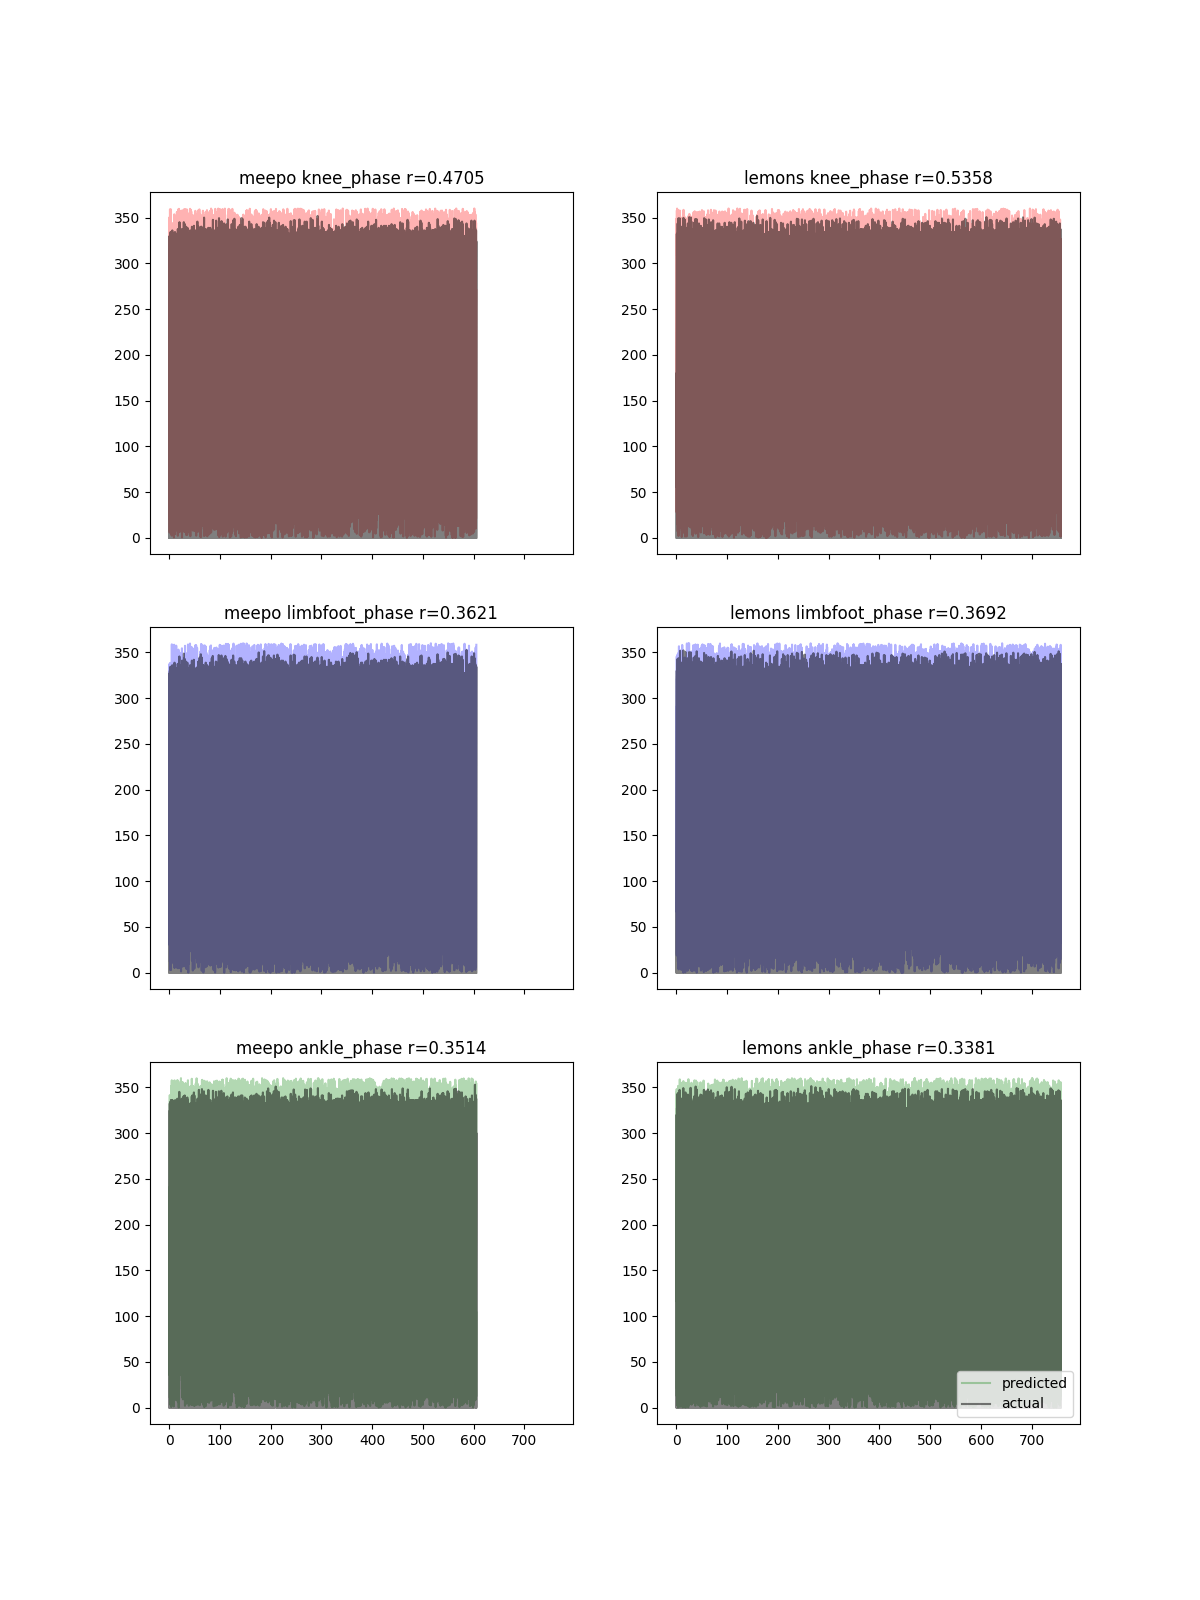

In [59]:
fig512, ax = plt.subplots(3,2, figsize=(12,16), sharex = True)
ax[0,0].set_title('meepo knee_phase r=' + f'{mep919r[1]:.{4}f}')
ax[0,0].plot(mep919tsf, mep919arctans[:,1], c='r', alpha=0.3, label = "predicted")
ax[0,0].plot(mep919tsf, mep919phase_list[:,1], c='k', alpha=0.5, label = "actual")
ax[0,1].set_title('lemons knee_phase r=' + "{0:.4f}".format(lem919r[1]))
ax[0,1].plot(lem919tsf, lem919arctans[:,1], c='r', alpha=0.3, label = "predicted")
ax[0,1].plot(lem919tsf, lem919phase_list[:,1], c='k', alpha=0.5, label = "actual")
ax[1,0].set_title('meepo limbfoot_phase r=' + f'{mep919r[3]:.{4}f}')
ax[1,0].plot(mep919tsf, mep919arctans[:,3], c='b', alpha=0.3, label = "predicted")
ax[1,0].plot(mep919tsf, mep919phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[1,1].set_title('lemons limbfoot_phase r=' + "{0:.4f}".format(lem919r[3]))
ax[1,1].plot(lem919tsf, lem919arctans[:,3], c='b', alpha=0.3, label = "predicted")
ax[1,1].plot(lem919tsf, lem919phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[2,0].set_title('meepo ankle_phase r=' + f'{mep919r[0]:.{4}f}')
ax[2,0].plot(mep919tsf, mep919arctans[:,0], c='g', alpha=0.3, label = "predicted")
ax[2,0].plot(mep919tsf, mep919phase_list[:,0], c='k', alpha=0.5, label = "actual")
ax[2,1].set_title('lemons ankle_phase r=' + "{0:.4f}".format(lem919r[0]))
ax[2,1].plot(lem919tsf, lem919arctans[:,0], c='g', alpha=0.3, label = "predicted")
ax[2,1].plot(lem919tsf, lem919phase_list[:,0], c='k', alpha=0.5, label = "actual")
ax[2,1].legend(loc="lower right")
fig512.tight_layout

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
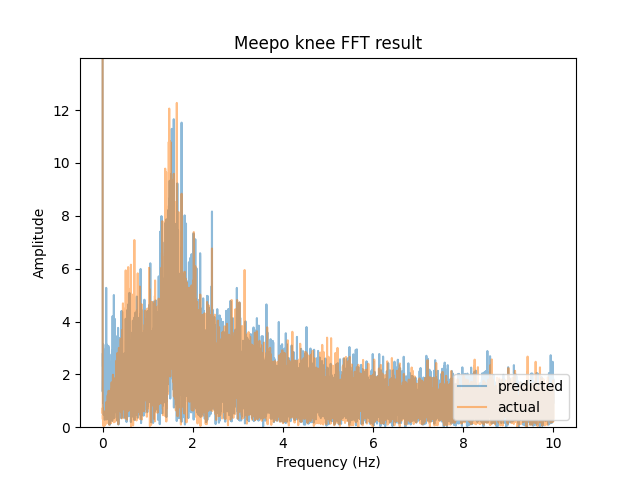

In [9]:
N = mep919tsf.shape[0]
# sample spacing
T = mep919tsf[1]-mep919tsf[0]
x = mep919tsf
y1 = mep919arctans[:,1]
y1f = fft(y1)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
y1fp = 2.0/N * np.abs(y1f[:N//2])
y2 = mep919phase_list[:,1]
y2f = fft(y2)
y2fp = 2.0/N * np.abs(y2f[:N//2])
fig, ax = plt.subplots()
ax.plot(xf, y1fp, alpha = 0.5, label='predicted')
ax.plot(xf, y2fp, alpha = 0.5, label='actual')
ax.set(ylabel='Amplitude',xlabel='Frequency (Hz)',title='Meepo knee FFT result')
ax.set_ylim([0, y1fp[np.argsort(y1fp, axis=0)[-2]] * 1.2]) 
ax.legend(loc='lower right')
plt.show()

In [110]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

print(list(colors)[0])
print(list(colors.values())[0])

b
(0, 0, 1)


In [115]:
           
def impulse_alignment(H_mat, phase_list, rates_array, AOI, count_thresh):
    padded_channel_response = impulse_response(H_mat, AOI, phase_list, plotting=False)
    rates_by_phase, phase_tracker = rates_by_gait(phase_list, rates_array, AOI, count_thresh, plotting = False)
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)
    colors = ['aliceblue', 'coral', 'burlywood','goldenrod','palegreen','paleturquoise','slategray','plum','cadetblue','crimson','chartreuse','gold',
'blueviolet','darkgreen','fuchsia','orchid', 'forestgreen','royalblue']
    impulse_bins = padded_channel_response[0].shape[0]
    x_values1=phase_tracker
    x_values2= np.arange(0,impulse_bins,1) 
    for i in range(rates_by_phase.shape[1]):
    # for i in range(0,1):
        color_index = i % len(colors)
        peak_percent = phase_tracker[np.argmax(rates_by_phase[:,i])]/360
        bin_roll = int(impulse_bins*peak_percent)
        padded_channel_response[i] = np.roll(padded_channel_response[i],bin_roll-1)
        ax.plot(x_values1, rates_by_phase[:,i],alpha=0.1,color=colors[color_index])
        ax2.plot(x_values2, padded_channel_response[i],color=colors[color_index])
    ax.set_xlabel("Phase Angle", color="C0")
    ax.set_ylabel("Spike Rate", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Impluse Response", color="C1")       
    ax2.xaxis.set_label_position('top') 
    ax2.yaxis.set_label_position('right') 
    ax2.tick_params(axis='x', colors="white")
    ax2.tick_params(axis='y', colors="C1")
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
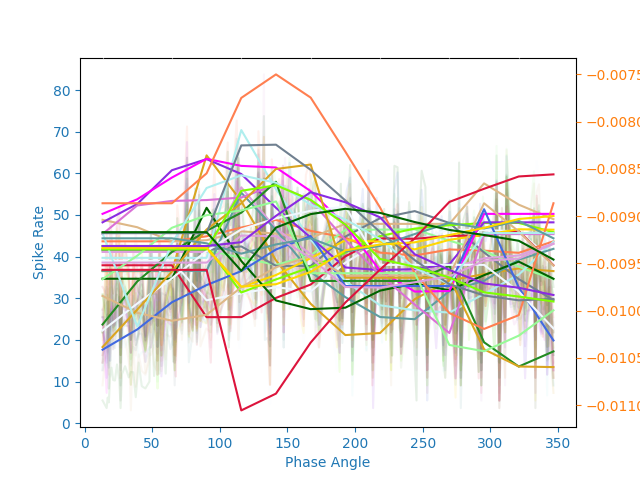

In [116]:
impulse_alignment(mep919H_cos, mep919phase_list, mep919full_rates, 3, 10)


In [ ]:
def impulse_response(H_mat, AOI, phase_list, plotting = False):
    column_response = []
    for i in range(0,32):
            product_list = []
            for j in range(0,10):
                dummyarray = np.zeros((10,32))
                dummyarray[-1,i] = 1
                dummyarray = np.roll(dummyarray,-j,axis = 0)
                dummyarray = dummyarray.flatten()
                dummyarray = np.insert(dummyarray,0,1)
                dummyarray = dummyarray.reshape(321,1)
                dummyarray = dummyarray.T
                product = np.dot(dummyarray, H_mat)
                product_list.append(product[0])
            product_list = np.array(product_list)
            column_response.append(product_list)
    av_gait_bins = average_gait_bins(phase_list, AOI)
    padded_column_response = []
    if (av_gait_bins - 10) >= 1:
        n = av_gait_bins-10
        for i in range(len(column_response)):
            padded_column = np.append(column_response[i][:,AOI], np.full((n,1), np.mean(column_response[i][:,AOI])))
            padded_column_response.append(padded_column)
        padded_column_response = np.array(padded_column_response)
    if plotting == True:
        fig1, ax1 = plt.subplots()
        x = np.arange(0,10,1)        
        for i in range(len(column_response)):
            ax1.plot(x, column_response[i][:,AOI])
        ax1.set_xticks(x)
    return padded_column_response

# def rates_by_gait(phase_list, rates_array, AOI, count_thresh, plotting = False):
#     unique_val, unique_first_index, unique_count = np.unique(phase_list, return_index=True, return_counts=True)
#     unique_range = len(unique_count)                  
#     rates_by_phase = []
#     phase_tracker = []
#     for i in range(1, unique_range):
#         if unique_count[i] >= count_thresh:
#             phase_tracker = np.append(phase_tracker, unique_val[i])
#             hodl = np.where(phase_list==unique_val[i])
#             hold = hodl[0]
#             hold_rates = []
#             for i in range(len(hold)):
#                 rates_row = rates_array[hold[i],-32:]
#                 hold_rates.append(rates_row)
#             hold_rates = np.mean(hold_rates, axis = 0)
#             rates_by_phase.append(hold_rates)
#     rates_by_phase = np.array(rates_by_phase)
#     if plotting == True:
#         fig1, ax1 = plt.subplots()
#         x = phase_tracker       
#         for i in range(rates_by_phase.shape[1]):
#             ax1.plot(x, rates_by_phase[:,i], alpha = 0.5)
#     return rates_by_phase, phase_tracker

def rates_by_gait(full_phase_list, rates_array, AOI, count_thresh, plotting = False):
    phase_list = full_phase_list[:,AOI]
    unique_val, unique_first_index, unique_count = np.unique(phase_list, return_index=True, return_counts=True)
    unique_range = len(unique_count)                  
    rates_by_phase = []
    phase_tracker = []
    for i in range(1, unique_range):
        if unique_count[i] >= count_thresh:
            phase_tracker = np.append(phase_tracker, unique_val[i])
            hodl = np.where(phase_list==unique_val[i])
            hold = hodl[0]
            hold_rates = []
            for i in range(len(hold)):
                rates_row = rates_array[hold[i],-32:]
                hold_rates.append(rates_row)
            hold_rates = np.mean(hold_rates, axis = 0)
            rates_by_phase.append(hold_rates)
    rates_by_phase = np.array(rates_by_phase)
    if plotting == True:
        fig1, ax1 = plt.subplots()
        x = phase_tracker       
        for i in range(rates_by_phase.shape[1]):
            ax1.plot(x, rates_by_phase[:,i], alpha = 0.5)
    return rates_by_phase, phase_tracker

def average_gait_bins(phase_list, AOI):
    gait_lengths = []
    gait_indicies = np.where(phase_list[:,AOI]==0)[0]
    for i in range(1, gait_indicies.shape[0]):
        gait_length = gait_indicies[i]-gait_indicies[i-1]
        gait_lengths = np.append(gait_lengths, gait_length)
    av_gait_length = math.ceil(np.average(gait_lengths))
    return av_gait_length

